In [4]:
import os
# check if session has spark
os.listdir()

['.config',
 'spark-3.5.1-bin-hadoop3.tgz.1',
 'spark-3.5.1-bin-hadoop3',
 'spark-3.5.1-bin-hadoop3.tgz',
 'drive',
 'sample_data']

In [3]:
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz

!pip install -q findspark
!pip install pyspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [3]:
# one time thing
#from google.colab import drive
# Mount Google Drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

# Start a Spark session
import findspark
findspark.init()

# Create a SparkSession
import pyspark
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName("MyApp").getOrCreate()


os.chdir('/content/drive/My Drive/USPS')

# Read the CSV file into a DataFrame (start with 0501 and if it works read the other two)
df = spark.read.csv('/content/drive/My Drive/USPS/gmu_dom_firstscan_20240501.csv',header = True, inferSchema = True)

# Create a temporary view for the DataFrame for queries
df.createOrReplaceTempView("data_table")


In [21]:
# Read the CSV file into a DataFrame
df2 = spark.read.csv('/content/drive/My Drive/USPS/gmu_dom_firstscan_20240502.csv',header = True, inferSchema = True)
# Read the CSV file into a DataFrame
df3 = spark.read.csv('/content/drive/My Drive/USPS/gmu_dom_firstscan_20240503.csv',header = True, inferSchema = True)


In [23]:
df2.createOrReplaceTempView("data_table2")
df3.createOrReplaceTempView("data_table3")

Check column infered schema:

In [19]:
# Get the column names
column_names = df.columns

# Get the data types of each column
data_types = [str(field.dataType) for field in df.schema.fields]

# Print the column names and data types
for i, column_name in enumerate(column_names):
    print(f"{i+1}. {column_name}: {data_types[i]}")

1. ciso_primary_key: LongType()
2. mailpieceid: StringType()
3. parcelidcode: StringType()
4. detailsequence: LongType()
5. createdtimestamp: TimestampType()
6. mailerid: StringType()
7. sourceid: StringType()
8. ServiceTypeCode: StringType()
9. applicationid: IntegerType()
10. constructcode: StringType()
11. mailclasscode: StringType()
12. USPSDimensionalHeight: DoubleType()
13. USPSDimensionalLength: DoubleType()
14. USPSDimensionalWidth: DoubleType()
15. customerrecordstartdate: DateType()
16. delinked: BooleanType()
17. MID_LAST_UPD_USERID: StringType()
18. MID_LAST_UPD_DATE: DateType()
19. CRID: StringType()
20. CRID_cmra_flag: StringType()
21. CRID_msp_flag: StringType()
22. UBK: StringType()
23. icr: IntegerType()
24. ict_filedate: DateType()
25. manifest: IntegerType()
26. manifest_createdtimestamp: TimestampType()
27. manifestid: StringType()
28. icr_or_manifest: IntegerType()
29. spef: IntegerType()
30. prtnrscan_createdtimestamp: TimestampType()
31. prtnrscan_eventcode: Stri

In [20]:
from pyspark.sql import functions as F

# Calculate min and max for each datetime column
min_max_df = spark.sql("""
SELECT
    min(customerrecordstartdate) AS min_customerrecordstartdate,
    max(customerrecordstartdate) AS max_customerrecordstartdate,
    min(ict_filedate) AS min_ict_filedate,
    max(ict_filedate) AS max_ict_filedate,
    min(createdtimestamp) AS min_createdtimestamp,
    max(createdtimestamp) AS max_createdtimestamp,
    min(manifest_createdtimestamp) AS min_manifest_createdtimestamp,
    max(manifest_createdtimestamp) AS max_manifest_createdtimestamp,
    min(prtnrscan_createdtimestamp) AS min_prtnrscan_createdtimestamp,
    max(prtnrscan_createdtimestamp) AS max_prtnrscan_createdtimestamp,
    min(firstscan_createdtimestamp) AS min_firstscan_createdtimestamp,
    max(firstscan_createdtimestamp) AS max_firstscan_createdtimestamp
FROM data_table
""")

# Show the results
min_max_df.show()

+---------------------------+---------------------------+----------------+----------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|min_customerrecordstartdate|max_customerrecordstartdate|min_ict_filedate|max_ict_filedate|min_createdtimestamp|max_createdtimestamp|min_manifest_createdtimestamp|max_manifest_createdtimestamp|min_prtnrscan_createdtimestamp|max_prtnrscan_createdtimestamp|min_firstscan_createdtimestamp|max_firstscan_createdtimestamp|
+---------------------------+---------------------------+----------------+----------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|                 1901-01-01|                 

In [24]:
# Calculate min and max for each datetime column
min_max_df = spark.sql("""
SELECT
    min(customerrecordstartdate) AS min_customerrecordstartdate,
    max(customerrecordstartdate) AS max_customerrecordstartdate,
    min(ict_filedate) AS min_ict_filedate,
    max(ict_filedate) AS max_ict_filedate,
    min(createdtimestamp) AS min_createdtimestamp,
    max(createdtimestamp) AS max_createdtimestamp,
    min(manifest_createdtimestamp) AS min_manifest_createdtimestamp,
    max(manifest_createdtimestamp) AS max_manifest_createdtimestamp,
    min(prtnrscan_createdtimestamp) AS min_prtnrscan_createdtimestamp,
    max(prtnrscan_createdtimestamp) AS max_prtnrscan_createdtimestamp,
    min(firstscan_createdtimestamp) AS min_firstscan_createdtimestamp,
    max(firstscan_createdtimestamp) AS max_firstscan_createdtimestamp
FROM data_table2
""")

# Show the results
min_max_df.show()

+---------------------------+---------------------------+----------------+----------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|min_customerrecordstartdate|max_customerrecordstartdate|min_ict_filedate|max_ict_filedate|min_createdtimestamp|max_createdtimestamp|min_manifest_createdtimestamp|max_manifest_createdtimestamp|min_prtnrscan_createdtimestamp|max_prtnrscan_createdtimestamp|min_firstscan_createdtimestamp|max_firstscan_createdtimestamp|
+---------------------------+---------------------------+----------------+----------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|                 1901-01-01|                 

In [25]:
# Calculate min and max for each datetime column
min_max_df = spark.sql("""
SELECT
    min(customerrecordstartdate) AS min_customerrecordstartdate,
    max(customerrecordstartdate) AS max_customerrecordstartdate,
    min(ict_filedate) AS min_ict_filedate,
    max(ict_filedate) AS max_ict_filedate,
    min(createdtimestamp) AS min_createdtimestamp,
    max(createdtimestamp) AS max_createdtimestamp,
    min(manifest_createdtimestamp) AS min_manifest_createdtimestamp,
    max(manifest_createdtimestamp) AS max_manifest_createdtimestamp,
    min(prtnrscan_createdtimestamp) AS min_prtnrscan_createdtimestamp,
    max(prtnrscan_createdtimestamp) AS max_prtnrscan_createdtimestamp,
    min(firstscan_createdtimestamp) AS min_firstscan_createdtimestamp,
    max(firstscan_createdtimestamp) AS max_firstscan_createdtimestamp
FROM data_table3
""")

# Show the results
min_max_df.show()

+---------------------------+---------------------------+----------------+----------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|min_customerrecordstartdate|max_customerrecordstartdate|min_ict_filedate|max_ict_filedate|min_createdtimestamp|max_createdtimestamp|min_manifest_createdtimestamp|max_manifest_createdtimestamp|min_prtnrscan_createdtimestamp|max_prtnrscan_createdtimestamp|min_firstscan_createdtimestamp|max_firstscan_createdtimestamp|
+---------------------------+---------------------------+----------------+----------------+--------------------+--------------------+-----------------------------+-----------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|                 1901-01-01|                 

In [26]:
print(f'0501 dataset: {df.count()}')
print(f'0502 dataset: {df2.count()}')
print(f'0503 dataset: {df3.count()}')

0501 dataset: 21347606
0502 dataset: 19499595
0503 dataset: 20408940


In [27]:
# Get the distinct counts for CRID_cmra_flag
crid_cmra_counts = df.groupby("CRID_cmra_flag").count()

# Get the distinct counts for CRID_msp_flag
crid_msp_counts = df.groupby("CRID_msp_flag").count()

# Print the counts
print(f"Distinct CRID_cmra_flag values: ")
crid_cmra_counts.show()
print(f"Distinct CRID_msp_flag values: ")
crid_msp_counts.show()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/content/spark-3.5.1-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/content/spark-3.5.1-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [28]:
# no NAs
df.groupby('icr_or_manifest').count().show()

+---------------+--------+
|icr_or_manifest|   count|
+---------------+--------+
|              1|20761161|
|              0|  586445|
+---------------+--------+



In [29]:
df2.groupby('icr_or_manifest').count().show()
df3.groupby('icr_or_manifest').count().show()

+---------------+--------+
|icr_or_manifest|   count|
+---------------+--------+
|              1|18942203|
|              0|  557392|
+---------------+--------+

+---------------+--------+
|icr_or_manifest|   count|
+---------------+--------+
|              1|19868697|
|              0|  540243|
+---------------+--------+



In [32]:
# Get the descriptive statistics for multiple columns
selected_columns = ["USPSDimensionalHeight", "USPSDimensionalWidth", "USPSDimensionalLength"]

df.describe().select("summary", *selected_columns).show()

+-------+---------------------+--------------------+---------------------+
|summary|USPSDimensionalHeight|USPSDimensionalWidth|USPSDimensionalLength|
+-------+---------------------+--------------------+---------------------+
|  count|             21256425|            21256425|             21256425|
|   mean|   1.5559226295109205|   4.561818407375751|    5.395867577920665|
| stddev|   2.3186212067547087|  5.2003055108801925|    6.062749855033602|
|    min|                  0.0|                 0.0|                  0.0|
|    max|               120.06|              400.25|               260.02|
+-------+---------------------+--------------------+---------------------+



In [39]:
import matplotlib.pyplot as plt

# Create a Series object for USPSDimensionalHeight
usps_dim_height_series = df["USPSDimensionalHeight"]

# Create a boxplot for USPSDimensionalHeight
usps_dim_height_series.plot.box()

# Display the plot
plt.show()

TypeError: 'Column' object is not callable

**Mailer Identifier** All barcodes from this mailer will contain this 6 or 9 digit string

In [34]:
print(df.select("mailerid").distinct().count())
print(df2.select("mailerid").distinct().count())
print(df3.select("mailerid").distinct().count())

94645
87868
84888


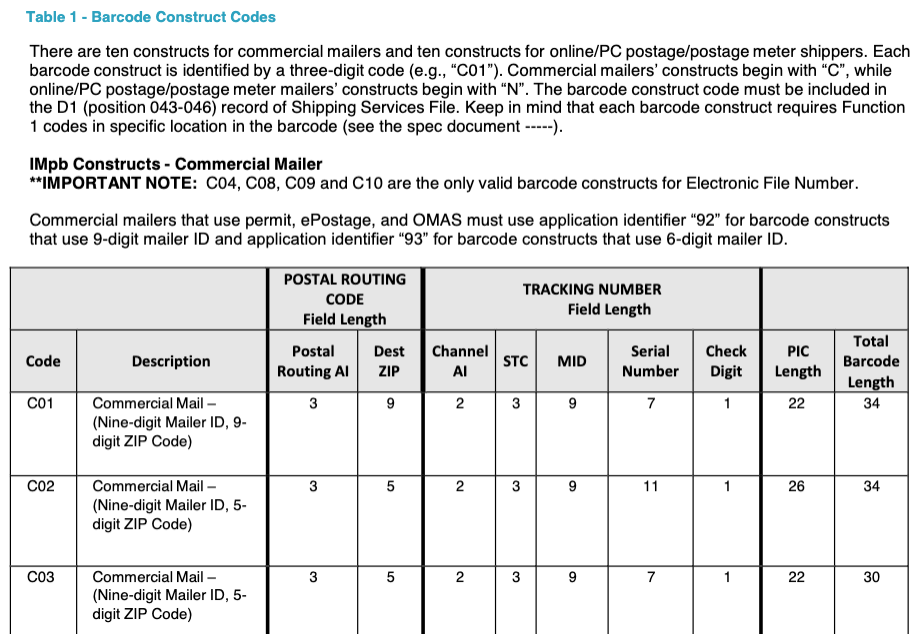

In [37]:
from IPython.display import Image
os.chdir('/content/drive/My Drive/USPS')
# Load the image
image_path = "/content/drive/My Drive/USPS/usps_tab.png"

# Display the image
Image(filename=image_path)

**Application Identifier**.  two-digit application identifier used to identify both the business induction channel from which the mailpiece originated and to indicate where Postal Service may locate a payment record for the mailpiece.
* Valid Channel Application Identifiers are “91”, “92”, “93”, “94”, and “95”.
* Data is filtered to just 92-94.
  * 92 - 93: for use by commercial mailers. (~73%)
    * 92 CommercialMailer–Nine-digitMID
    * 93 - CommercialMailer–Six-digitMID
  * 94: For use by PC Postage and online systems. (~26%)
    * WebTools/PCPostageVendor/PostageMeters

In [35]:
df.groupby('applicationid').count().show()
df2.groupby('applicationid').count().show()
df3.groupby('applicationid').count().show()

+-------------+-------+
|applicationid|  count|
+-------------+-------+
|           93|6804106|
|           94|5263769|
|           92|9279731|
+-------------+-------+

+-------------+-------+
|applicationid|  count|
+-------------+-------+
|           93|6564409|
|           94|4952839|
|           92|7982347|
+-------------+-------+

+-------------+-------+
|applicationid|  count|
+-------------+-------+
|           93|6992029|
|           94|4676545|
|           92|8740366|
+-------------+-------+



In [46]:
# Save the SparkSession to a file
spark.sparkContext.setCheckpointDir("/content/drive/My Drive/USPS/spark_checkpoint")
# Stop the SparkSession
#spark.stop()


In [48]:


# Load the saved SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MyApp").getOrCreate()
spark.sparkContext.setCheckpointDir("/content/drive/My Drive/USPS/spark_checkpoint")

In [47]:
os.listdir()

['gmu_dom_firstscan_20240502.zip',
 'gmu_dom_firstscan_20240503.zip',
 'gmu_dom_firstscan_20240502.csv',
 'gmu_dom_firstscan_20240503.csv',
 'gmu_dom_firstscan_20240501.csv.zip',
 'gmu_dom_firstscan_20240501.csv',
 '__MACOSX',
 'Parquet',
 'parq_files',
 'Data_Dictionary.xlsx',
 'usps_tab.png',
 'spark_checkpoint']

In [ ]:
print(df.select("mailerid").distinct().count())

In [ ]:
min_max_df.show()